## Example 03 - Basic simulation - consumes energy-current-6-2.5-6
In this notebook, we are going to make a simulation which forces a vessel to move over a certain 1D waterway network. It tries to give one an understanding of the most basic core functions of OpenTNSim and teach one the requirements to set-up a basic OpenTNSim model run. 

We add some properties to the graph (depth) and the vessel (VesselProperties, HasContainer, ConsumesEnergy) in order to calculate resistance, required power, 

### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx   

### Create graph
We first need to create a 1D network (a graph) along which the vessel will move. A graph contains edges (blue dots in plot below) and vertices (black lines in plot below). For this example, we will construct a network consisting of 4 nodes in a straight line. Since we would like to have two-way traffic, we add two edges between each pair of nodes: one from left to right, and another the other way around (however, we could easily apply one-way traffic as well by remove one of the two edges). Consequently, we arrive at a total of 4 nodes, and 6 edges.

Due to the nature of discrete modelling in which the time step is dependent on the activities (in this example: forcing a ship to move from node to node from its origin to its destination), it is important to add OpenTNSim mix-ins to the nodes in such a way we could identify the node (mix-in Identifiable, which imports a name and imports/creates an ID), and to locate the node (mix-in Locatable, which gives the node a geometry).

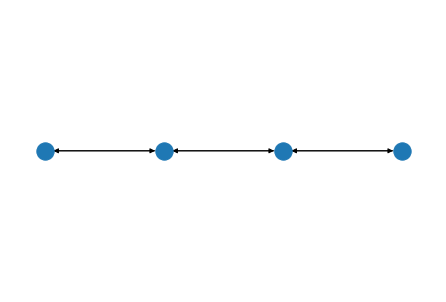

In [2]:
FG = nx.DiGraph()
nodes = []
path = []

Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

data_node_1 = {"name": "Node 1",
               "geometry": shapely.geometry.Point(0, 0)}
data_node_2 = {"name": "Node 2",
               "geometry": shapely.geometry.Point(0.8983, 0)}  # 0.8983 degree =100km
data_node_3 = {"name": "Node 3",
               "geometry": shapely.geometry.Point(1.7966, 0)}   # 1.7966 degree =200km
data_node_4 = {"name": "Node 4",
               "geometry": shapely.geometry.Point(2.6949, 0)}    # 2.6949 degree =300km

node_1 = Node(**data_node_1)
node_2 = Node(**data_node_2)
node_3 = Node(**data_node_3)
node_4 = Node(**data_node_4)

nodes = [node_1, node_2, node_3, node_4]

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

path = [[node_1, node_2], # From node 1 to node 2
        [node_2, node_3], # From node 2 to node 3
        [node_3, node_4], # From node 3 to node 4
        [node_4, node_3], # From node 4 to node 3
        [node_3, node_2], # From node 3 to node 2
        [node_2, node_1]] # From node 2 to node 1

for edge in path:
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    if edge == [node_2, node_3] or edge == [node_3, node_2]:
        FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {"GeneralDepth": 2.5})
    else:
        FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {"GeneralDepth": 6})
    
# env.FG = FG
nx.draw(FG, positions)
plt.show()

In [3]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))

General depth for edge ('Node 1', 'Node 2') is 6
General depth for edge ('Node 2', 'Node 3') is 2.5
General depth for edge ('Node 2', 'Node 1') is 6
General depth for edge ('Node 3', 'Node 4') is 6
General depth for edge ('Node 3', 'Node 2') is 2.5
General depth for edge ('Node 4', 'Node 3') is 6


### Create vessel - add VesselProperties and ConsumesEnergy mixins
The following mix-ins are required for each vessel in our problem: Identifiable (gives the vessel a name and a random ID), Movable (gives that the object (*vessel*) can move with a fixed speed and logs this activity, it requires input for the following mix-ins: Locatable, Routeable, and Log), and Routable (gives the object a route). We now modify our original vessel from the basic example and include vessel properties (like width, length, etc.) and a mixin that is needed to calculate resistance and energy consumption.  

In [4]:
# Make your preferred class out of available mix-ins.
TransportResource = type('Vessel', 
                         (opentnsim.core.Identifiable, 
                          opentnsim.core.Movable, 
                          opentnsim.core.Routeable,
                          opentnsim.core.VesselProperties,     # needed to add vessel properties
                          opentnsim.core.HasContainer,         # needed to calculate filling degree for draught
                          opentnsim.core.ConsumesEnergy), {})  # needed to calculate resistances            

In [5]:
# Create a dict with all important settings
data_vessel = {"env": None,
               "name": None,
               "route": None,
               "geometry": None,
               "v":3.5,  # m/s
               "type": 'Dortmund-Eems (L <= 74 m)', # <-- note that inputs from hereon are due to the added mixins!
               "B": 11.4,
               "L": 110,
               "capacity": 3000,   # maximum designed payload
               "level":3000,     # actual payload
               "H_e": None, 
               "H_f": None, 
               "T_e":None, 
               "T_f":None, 
               "P_installed":1750.0,   
               "P_given":None,
               "L_w": 3.0 ,
               "C_b":0.85, 
               "c_year":1990,
               "current_year":None
              }               

vessel = TransportResource(**data_vessel)

### Define paths
We are going to create a simulation in which a vessel moves from *Node 1* to *Node 4*. Therefore, we need to create a vessel to which we will need to append this paths. Therefore, first let's create the path.

In [6]:
path = nx.dijkstra_path(FG, node_1.name, node_4.name)

### Run simulation
Now we can define the run. First, we make an environment and add the graph to the environment. Then we add one vessel, to which we will append the environment and the above route. Lastly, we give the vessel the process of moving from the origin to the destination of the defined path and subsequently run the model.

In [7]:
# Start simpy environment
simulation_start = datetime.datetime.now()
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.epoch = time.mktime(simulation_start.timetuple())

# Add graph to environment
env.FG = FG

# Add environment and path to the vessel
vessel.env = env                                        #the created environment
vessel.name = 'Vessel No.1'                     
vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)

In [8]:
h_min = np.inf
for index, edge in enumerate(vessel.route[:-1]):
    # step through each edge and adjust the minimum if it is lower than the previous minimum (start at inf)
    h_min = np.min([h_min, FG.get_edge_data(vessel.route[index], vessel.route[index+1])["Info"]["GeneralDepth"]])

print('minimal depth on route is: {} m'.format(h_min))

minimal depth on route is: 2.5 m


In [9]:
#draught, payload = vessel.calculate_actual_T_and_payload(h_min, 0.3)
draught, payload = vessel.calculate_actual_T_and_payload(h_min, 0.3, "Dry_DH") #draught, payload = vessel.calculate_actual_T_and_payload(h_min, ukc, vesl_type)
                                                                    #  should be "Container","Dry_DH","Dry_SH","Barge" or "Tanker"'
print(draught)
print(payload)

The actual draft is 2.2 m
The actual_max_payload is 1393.8605768943894 ton
2.2
1393.8605768943894


In [10]:
# Start the simulation
env.process(vessel.move())
env.run()

### Output
We can now analyse the output of the simulation, which consists of the log-file of the vessel. We got this log-file as we added the log mix-in of OpenTNSim. This log-file keeps track of the moving activities of the vessel, and at which time and location they occur. The log-file could also keep track of an additional value, such as waiting times, which are not included here in this simulation.

As you can see, the vessel moves from its origin (*Node 1*) to its destination (*Node 4*) by passing *Node 2* and *Node 3* respectively. The time is calculated by the greater circle distance between the nodes, divided by the speed of the vessel.

Using this log-file, we could for example plot a time-distance graph.

In [11]:
df = pd.DataFrame.from_dict(vessel.log)
df

,Message,Timestamp,Value,Geometry
0,Sailing from node Node 1 to node Node 2 start,2021-06-23 09:18:16.000000,0,POINT (0 0)
1,Sailing from node Node 1 to node Node 2 stop,2021-06-23 17:14:26.942451,0,POINT (0.8983 0)
2,Sailing from node Node 2 to node Node 3 start,2021-06-23 17:14:26.942451,0,POINT (0.8983 0)
3,Sailing from node Node 2 to node Node 3 stop,2021-06-24 01:10:37.884902,0,POINT (1.7966 0)
4,Sailing from node Node 3 to node Node 4 start,2021-06-24 01:10:37.884902,0,POINT (1.7966 0)
5,Sailing from node Node 3 to node Node 4 stop,2021-06-24 09:06:48.827354,0,POINT (2.6949 0)


### Post processing: calculate energy consumptions and emissions

In [12]:
# create an EnergyCalculation object (graph FG and vessel are needed as input)
energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)

In [13]:
# we can now work out in hindsight what resistance, power, energy and emissions were generated
energycalculation.calculate_energy_consumption()

# ToDo:
# - perhaps add to the printstatements which edge is sailed 
# - may be the print statements can be cleaned up (fewer significant digits)
# - possibly even make it optional to print this, because the next cells show dataframes with the output
# - etc

delta_t: 28570.9425 s
distance: 99998.2986 m
velocity: 3.5000 m/s
The total power required is 371.1320287538226 kW
The actual total power given is 371.1320287538226 kW
The partial load is 0.21207544500218437
The construction year of the engine is 1990
The general emission factor of CO2 is 698 g/kWh
The general emission factor of PM10 is 0.4 g/kWh
The general emission factor CO2 is 10.1 g/kWh
The general fuel consumption factor is 220 g/kWh
The total power required is 371.1320287538226 kW
The actual total power given is 371.1320287538226 kW
The partial load is 0.21207544500218437
Correction factor of CO2 is 1.1451698219991262
Correction factor of PM10 is 1.173094376996942
Correction factor of NOX is 1.0903396439982527
Correction factor of fuel consumption is 1.1451698219991262
The total emission factor of CO2 is 799.3285357553901 g/kWh
The total emission factor of PM10 is 0.46923775079877683 g/kWh
The total emission factor CO2 is 11.012430404382352 g/kWh
The total fuel consumption facto

In [14]:
df = pd.DataFrame.from_dict(energycalculation.energy_use)
df['diesel_kg_km'] = df['total_fuel_consumption'] / df['distance']*1000
df['CO2_g_km'] = df['total_emission_CO2'] / df['distance']*1000
df['PM10_g_km'] = df['total_emission_PM10'] / df['distance']*1000
df['NOX_g_km'] = df['total_emission_NOX'] / df['distance']*1000

## Add current influence

In [15]:
# with current speed =0.5m/s
V_cur=0.5 
# delta_t will be longer when upstream, shorter when downstream
delta_t_up=df['distance']/(df['distance']/df['delta_t']-V_cur)
delta_t_down=df['distance']/(df['distance']/df['delta_t']+V_cur)
# total emission&fuel consumption will be large when upstream(because of longer delta_t), shorter when downstream(because of shorter delta_t)
df['total_fuel_consumption_kg']=df['total_fuel_consumption'] #kg without current
df['total_fuel_consumption_up_kg']=df['total_fuel_consumption'] *(delta_t_up/df['delta_t']) #kg
df['total_fuel_consumption_down_kg']=df['total_fuel_consumption'] *(delta_t_down/df['delta_t']) #kg
df['total_fuel_consumption_round_no_current_kg']=df['total_fuel_consumption']*2 #kg
df['total_fuel_consumption_round_current_kg']=df['total_fuel_consumption_up_kg']+df['total_fuel_consumption_down_kg'] #kg
df['total_emission_CO2_kg']=df['total_emission_CO2']/1000 #kg without current
df['total_emission_CO2_up_kg']=df['total_emission_CO2'] *(delta_t_up/df['delta_t'])/1000 #kg
df['total_emission_CO2_down_kg']=df['total_emission_CO2'] *(delta_t_down/df['delta_t'])/1000 #kg
df['total_emission_CO2_round_no_current_kg']=df['total_emission_CO2']*2/1000 #kg
df['total_emission_CO2_round_current_kg']=df['total_emission_CO2_up_kg']+df['total_emission_CO2_down_kg'] #kg
df['total_emission_PM10_kg']=df['total_emission_PM10']/1000 #kg without current
df['total_emission_PM10_up_kg']=df['total_emission_PM10'] *(delta_t_up/df['delta_t'])/1000 #kg
df['total_emission_PM10_down_kg']=df['total_emission_PM10'] *(delta_t_down/df['delta_t'])/1000 #kg
df['total_emission_PM10_round_no_current_kg']=df['total_emission_PM10']*2/1000 #kg
df['total_emission_PM10_round_current_kg']=df['total_emission_PM10_up_kg']+df['total_emission_PM10_down_kg'] #kg
df['total_emission_NOX_kg']=df['total_emission_NOX']/1000 #kg without current
df['total_emission_NOX_up_kg']=df['total_emission_NOX'] *(delta_t_up/df['delta_t'])/1000 #kg
df['total_emission_NOX_down_kg']=df['total_emission_NOX'] *(delta_t_down/df['delta_t'])/1000 #kg
df['total_emission_NOX_round_no_current_kg']=df['total_emission_NOX']*2/1000 #kg
df['total_emission_NOX_round_current_kg']=df['total_emission_NOX_up_kg']+df['total_emission_NOX_down_kg'] #kg

In [16]:
fuel=df[['total_fuel_consumption_kg','total_fuel_consumption_up_kg','total_fuel_consumption_down_kg',
          'total_fuel_consumption_round_no_current_kg','total_fuel_consumption_round_current_kg']].T
fuel.index=['single trip \n no current \n either way', 'single trip \n upstream',
                    'single trip \n downstream', 'round trip \n no current', 'round trip \n current']
fuel.columns =['section 1','section 2','section 3']
fuel.head()

,section 1,section 2,section 3
single trip \n no current \n either way,742.066928,2401.316463,742.066928
single trip \n upstream,865.744750,2801.535873,865.744750
single trip \n downstream,649.308562,2101.151905,649.308562
round trip \n no current,1484.133857,4802.632926,1484.133857
round trip \n current,1515.053312,4902.687779,1515.053312


(array([    0.,  2000.,  4000.,  6000.,  8000., 10000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

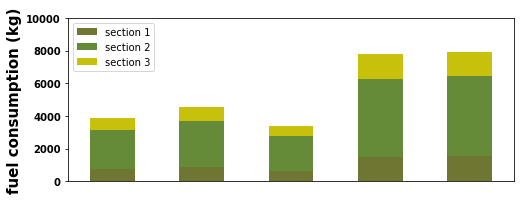

In [17]:
# creates a stacked bar plot
fuel_colors=['#6f7632','#658b38','#c7c10c']
fuel.plot(kind='bar', stacked=True,color=fuel_colors,rot=0, figsize=(8, 3))
plt.ylim(0, 10000)
plt.ylabel('fuel consumption (kg)',fontsize=15,fontweight='bold')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
plt.yticks( weight = 'bold')

In [18]:
CO2=df[['total_emission_CO2_kg','total_emission_CO2_up_kg','total_emission_CO2_down_kg',
          'total_emission_CO2_round_no_current_kg','total_emission_CO2_round_current_kg']].T
CO2.index=['single trip \n no current \n either way', 'single trip \n upstream',
                    'single trip \n downstream', 'round trip \n no current', 'round trip \n current']
CO2.columns =['section 1','section 2','section 3']
CO2.head()


,section 1,section 2,section 3
single trip \n no current \n either way,2354.375982,7618.722232,2354.375982
single trip \n upstream,2746.771979,8888.509271,2746.771979
single trip \n downstream,2060.078984,6666.381953,2060.078984
round trip \n no current,4708.751964,15237.444465,4708.751964
round trip \n current,4806.850963,15554.891225,4806.850963


<AxesSubplot:>

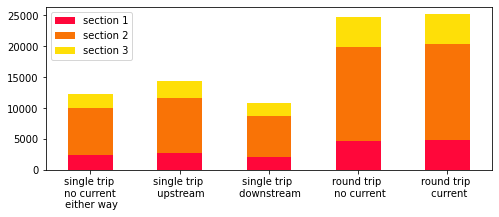

In [19]:
# creates a stacked bar plot
CO2_colors=['#ff073a','#f97306','#fedf08']
CO2.plot(kind='bar', stacked=True,color=CO2_colors,rot=0, figsize=(8, 3))

In [20]:
PM10=df[['total_emission_PM10_kg','total_emission_PM10_up_kg','total_emission_PM10_down_kg',
          'total_emission_PM10_round_no_current_kg','total_emission_PM10_round_current_kg']].T
PM10.index=['single trip \n no current \n either way', 'single trip \n upstream',
                    'single trip \n downstream', 'round trip \n no current', 'round trip \n current']
PM10.columns =['section 1','section 2','section 3']
PM10.head()

,section 1,section 2,section 3
single trip \n no current \n either way,1.382113,4.278709,1.382113
single trip \n upstream,1.612465,4.991828,1.612465
single trip \n downstream,1.209349,3.743871,1.209349
round trip \n no current,2.764225,8.557419,2.764225
round trip \n current,2.821813,8.735698,2.821813


<AxesSubplot:>

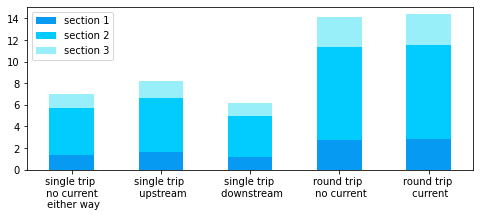

In [21]:
# creates a stacked bar plot
PM10_colors=['#069af3','#02ccfe','#98eff9']
PM10.plot(kind='bar', stacked=True,color=PM10_colors,rot=0, figsize=(8, 3))

In [22]:
NOX=df[['total_emission_NOX_kg','total_emission_NOX_up_kg','total_emission_NOX_down_kg',
          'total_emission_NOX_round_no_current_kg','total_emission_NOX_round_current_kg']].T
NOX.index=['single trip \n no current \n either way', 'single trip \n upstream',
                    'single trip \n downstream', 'round trip \n no current', 'round trip \n current']
NOX.columns =['section 1','section 2','section 3']
NOX.head()

,section 1,section 2,section 3
single trip \n no current \n either way,32.436477,107.245899,32.436477
single trip \n upstream,37.842556,125.120215,37.842556
single trip \n downstream,28.381917,93.840161,28.381917
round trip \n no current,64.872954,214.491797,64.872954
round trip \n current,66.224474,218.960376,66.224474


<AxesSubplot:>

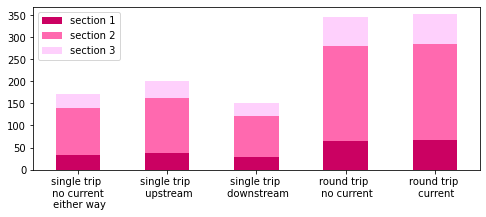

In [23]:
# creates a stacked bar plot
NOX_colors=['#cb0162','#ff69af','#fed0fc']
NOX.plot(kind='bar', stacked=True,color=NOX_colors,rot=0, figsize=(8, 3))

## Figure: 
### a waterway with water depth=6m, total distance=300km, and an 100km long shallow part(water depth=2.5m) in the center

In [24]:
# section=fuel.T
# section

In [25]:
# import numpy as np
# import matplotlib.pyplot as plt

# def plot_stacked_bar(data, series_labels, category_labels=None, 
#                      show_values=False, value_format="{}", y_label=None, 
#                      colors=None, grid=False,ylim=True, reverse=False):
#     """Plots a stacked bar chart with the data and labels provided.

#     Keyword arguments:
#     data            -- 2-dimensional numpy array or nested list
#                        containing data for each series in rows
#     series_labels   -- list of series labels (these appear in
#                        the legend)
#     category_labels -- list of category labels (these appear
#                        on the x-axis)
#     show_values     -- If True then numeric value labels will 
#                        be shown on each bar
#     value_format    -- Format string for numeric value labels
#                        (default is "{}")
#     y_label         -- Label for y-axis (str)
#     colors          -- List of color labels
#     grid            -- If True display grid
#     reverse         -- If True reverse the order that the
#                        series are displayed (left-to-right
#                        or right-to-left)
#     """

#     ny = len(data[0])
#     ind = list(range(ny))

#     axes = []
#     cum_size = np.zeros(ny)

#     data = np.array(data)

#     if reverse:
#         data = np.flip(data, axis=1)
#         category_labels = reversed(category_labels)

#     for i, row_data in enumerate(data):
#         color = colors[i] if colors is not None else None
#         axes.append(plt.bar(ind, row_data, bottom=cum_size, 
#                             label=series_labels[i], color=color))
#         cum_size += row_data

#     if category_labels:
#         plt.xticks(ind, category_labels)

#     if y_label:
#         plt.ylabel(y_label)

#     plt.legend()

#     if grid:
#         plt.grid()
#     if ylim:
#         plt.ylim(ylim)

#     if show_values:
#         for axis in axes:
#             for bar in axis:
#                 w, h = bar.get_width(), bar.get_height()
#                 plt.text(bar.get_x() + w/2, bar.get_y() + h/2, 
#                          value_format.format(h), ha="center", 
#                          va="center")

In [26]:
# lengend = ['section 1','section 2','section 3']

# data = fuel.T
# data2 = CO2.T  

# category_labels =['single trip \n no current \n either way', 'single trip \n upstream',
#                     'single trip \n downstream', 'round trip \n no current', 'round trip \n current']

# fig,ax=plt.subplots(4, 1, sharex=True, figsize=(8, 12))

# plt.subplot(411)
# plot_stacked_bar(
#     data, 
#     lengend, 
#     category_labels=category_labels, 
#     show_values=True, 
#     value_format="{:.1f}",
#     colors=fuel_colors,
#     ylim=(0,10000),
#     y_label="fuel consumption (kg)",
#     grid=False,
#     reverse=False 
# )

# # plt.subplot(412)

# # plot_stacked_bar(
# #     data, 
# #     lengend, 
# #     category_labels=category_labels, 
# #     show_values=True, 
# #     value_format="{:.1f}",
# #     colors=CO2_colors,
# #     ylim=(0,30000),
# #     y_label="Total CO2 emission (kg)",
# #     grid=False,
# #     reverse=False 
# # )



# plt.savefig('bar.png')
# plt.show()

<Figure size 432x288 with 0 Axes>

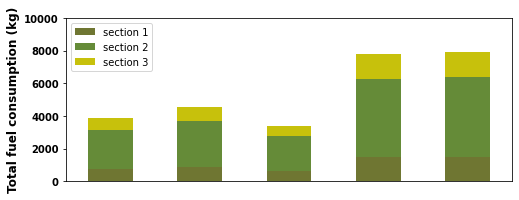

<Figure size 432x288 with 0 Axes>

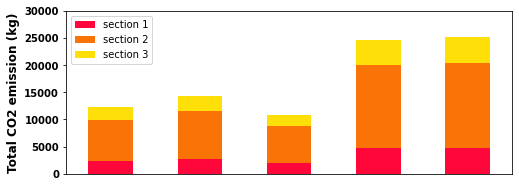

<Figure size 432x288 with 0 Axes>

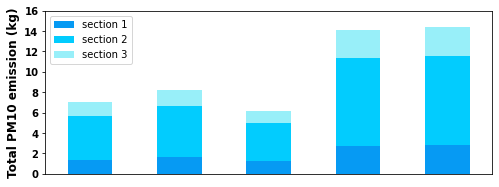

<Figure size 432x288 with 0 Axes>

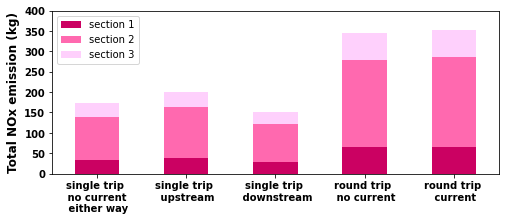

In [35]:
# fig,ax=plt.subplots(4, 1, sharex=True)

plt.figure()
# plt.subplot(411)
fuel.plot(kind='bar', stacked=True,color=fuel_colors,rot=0,figsize=(8, 3))
plt.ylim(0, 10000)
plt.ylabel('Total fuel consumption (kg)',fontsize=12,fontweight='bold')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
plt.yticks( weight = 'bold')
plt.savefig('6-2.5-6current-fuel', dpi=600, format='tif')    

plt.figure()
# plt.subplot(412)
CO2.plot(kind='bar', stacked=True,color=CO2_colors,rot=0,figsize=(8, 3))
plt.ylim(0, 30000)
plt.ylabel('Total CO2 emission (kg)',fontsize=12,fontweight='bold')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
plt.yticks( weight = 'bold')
plt.savefig('6-2.5-6current-CO2', dpi=600, format='tif') 

plt.figure()
# plt.subplot(413)
PM10.plot(kind='bar', stacked=True,color=PM10_colors,rot=0,figsize=(8, 3))
plt.ylim(0, 16)
plt.ylabel('Total PM10 emission (kg)',fontsize=12,fontweight='bold')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
plt.yticks( weight = 'bold')
plt.savefig('6-2.5-6current-PM10', dpi=600, format='tif') 
plt.figure()
# plt.subplot(414)
NOX.plot(kind='bar', stacked=True,color=NOX_colors,rot=0,figsize=(8, 3))
plt.ylim(0, 400)
plt.ylabel('Total NOx emission (kg)',fontsize=12,fontweight='bold')
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.savefig('6-2.5-6current-NOX', dpi=600, format='tif') 


plt.show()